In [1]:
import igraph
import dgl
import torch
import heapq
import time
import pickle
import logging
import os

## Funciones heurísticas para comparar

In [2]:
def bfs(graph: igraph.Graph, d: int):
    if d <= 1:
        return graph.copy()

    n = graph.vcount()
    es = []

    for v in range(n):
        layers = [0] * n
        visited, queue = set([v]), deque([v])
        while queue:
            vertex = queue.popleft()
            for neighbor in graph.successors(vertex):
                if neighbor not in visited and layers[vertex] < d:
                    visited.add(neighbor) 
                    queue.append(neighbor)
                    layers[neighbor] = layers[vertex] + 1
        visited.remove(v)
        es.extend([(v, u) for u in visited])
    
    extended_graph = igraph.Graph(n=n, directed=True)
    extended_graph.add_edges(es)
    return extended_graph
class Node:
    def __init__(self, id, value):
        self.id = id
        self.value = value

    def __lt__(self, other):
        return self.value < other.value

    def __str__(self):
        # we store the negative value to use max heap.
        return f"{self.id}: {-self.value}"
    
def greedy(closed_graph: igraph.Graph, k: int, debug=False):
    """find k-max d-hop cover with greedy

    Args:
        graph (igraph.Graph): graph
        k (int): the number of seeds k
        debug (bool): debug mode

    Returns:
        seeds, covernum: selected seeds, and the seed count
    """
    seeds = []

    nodes_num = closed_graph.vcount()
    covered = [False] * nodes_num
    cover_num = 0

    inf_list = [deg + 1 for deg in closed_graph.outdegree()]

    node_queue = [Node(i, -inf_list[i]) for i in range(nodes_num)]
    heapq.heapify(node_queue)
    i = 0

    while i < k and cover_num < nodes_num:  # while there's still free point or unused budget

        # Find the node with max marginal utility
        max_inf_node = heapq.heappop(node_queue)
        if inf_list[max_inf_node.id] != - max_inf_node.value:
            max_inf_node.value = -inf_list[max_inf_node.id]
            heapq.heappush(node_queue, max_inf_node)
            continue

        i += 1
        seeds.append(max_inf_node.id)
        if not covered[max_inf_node.id]:  # Update predecessors
            covered[max_inf_node.id] = True  # 1. mark max_node as covered
            cover_num += 1
            inf_list[max_inf_node.id] -= 1
            # 2. all the preds have influence -1
            for predecessor in closed_graph.predecessors(max_inf_node.id):
                inf_list[predecessor] -= 1

        # Update successors
        for successor in closed_graph.successors(max_inf_node.id):
            if not covered[successor]:
                # 1. mark all the successors as covered
                covered[successor] = True
                cover_num += 1
                # 2. all the successors have influence -1 (since there is no unitility to cover themselves)
                inf_list[successor] -= 1
                # 3. all the (predecessors of successors) have influence -1
                for predecessor in closed_graph.predecessors(successor):
                    inf_list[predecessor] -= 1

        if debug:
            print(
                f"Round {i}: {max_inf_node.id} is selected. {cover_num} nodes are covered.")
                
    return seeds, cover_num

In [3]:
def get_adj_mat(graph, d=1):
    if d == 1:
        adj_mat = np.array(graph.get_adjacency().data, dtype=bool)
        adj_mat = torch.from_numpy(np.array(adj_mat, dtype=int)).float().cpu()
        adj_mat += torch.eye(graph.vcount()).cpu()
        return adj_mat.cpu()
    elif d == 2:
        return get_adj_mat_2(graph)

## Funciones necesarias para correr el código

In [4]:
def get_graph_names(path_to_test):
    graph_names = []
    for rt, _, files in os.walk(path_to_test):
        if rt == path_to_test:
            for file in files:
                if file.endswith('.txt'):
                    graph_names.append(file)
    return graph_names

In [7]:
def gen_zero_feature(graph, feature_dim):
    """Generate all-zero features
    """
    return torch.zeros(graph.vcount(), feature_dim)


def gen_one_feature(graph, feature_dim):
    """Generate all-one features
    """
    return torch.ones(graph.vcount(), feature_dim)


def gen_deg_feature(graph, *args):  # args is only a placeholder
    indegree = torch.tensor(graph.indegree()).float()
    zeros = torch.zeros(graph.vcount(), 1).squeeze(1)
    return torch.stack([indegree, zeros], dim=1)


def gen_one_hot_feayture(graph, *args):  # args is only a placeholder
    return torch.eye(graph.vcount()).float()


FEATURE_TYPE_DICT = {
    "0": gen_zero_feature,
    "1": gen_one_feature,
    "onehot": gen_one_hot_feayture,
    "deg": gen_deg_feature,
}

def get_rev_dgl(graph, feature_type='0', feature_dim=None, is_directed=False, use_cuda=False):
    """get dgl graph from igraph
    """
    
    src, dst = zip(*graph.get_edgelist())

    if use_cuda:
        dglgraph = dgl.graph((dst, src)).to(torch.device("cuda:0"))
    else:
        dglgraph = dgl.graph((dst, src))
        
    if not is_directed:
        dglgraph.add_edges(src, dst)

    if use_cuda:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim).cuda()
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float().cuda()

    else:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim)
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float()
        
    return dglgraph


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.softmax import edge_softmax
# Guanhao's GRAT
class GRATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        # TODO: why not another linear layer before entering the net
        super(GRATLayer, self).__init__()
        # linear layer
        self.fc = nn.Linear(in_feats, out_feats, bias=True)  # bias=True in Guanhao's original code
        
        # attention layer
        self.attn_fc = nn.Linear(2 * in_feats, 1, bias=True)  # bias=True in Guanhao's original code

        # initialize parameters
        # self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        h2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(h2)
        return {'e': torch.relu(a)}

    def message_func(self, edges):
        return {'h': edges.src['h'] * edges.data['alpha']}  # message divided by weight

    def reduce_func(self, nodes):
        return {'h': torch.sum(nodes.mailbox['h'], dim=1)}

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            # Equation (2)
            g.apply_edges(self.edge_attention)  # calculate e_{ij}

            # Calculate softmax on source code -> on the reversed graph
            rg = g.reverse(copy_ndata=False, copy_edata=True)
            g.edata['alpha'] = edge_softmax(rg, rg.edata['e'])
            
            # Convolution
            g.update_all(self.message_func, self.reduce_func)
            
            g.ndata['h'] = self.fc(g.ndata['h'])
            h = g.ndata['h']
            return h


# GRAT more similar to GAT 
class GRATVLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GRATVLayer, self).__init__()
        # linear layer
        self.fc = nn.Linear(in_feats, out_feats, bias=False)  # bias=True in Guanhao's original code
        # attention layer
        self.attn_fc = nn.Linear(2 * out_feats, 1, bias=False)  # bias=True in Guanhao's original code
        # initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        return {'h': edges.src['z'] * edges.data['alpha']}  # message divided by weight

    def reduce_func(self, nodes):
        return {'h': torch.sum(nodes.mailbox['h'], dim=1)}

    def forward(self, g, feature):
        with g.local_scope():
            z = self.fc(feature)
            g.ndata['z'] = z
            # Equation (2)
            g.apply_edges(self.edge_attention)  # calculate e_{ij}
            # Calculate softmax on source code -> on the reversed graph
            rg = g.reverse(copy_ndata=False, copy_edata=True)
            g.edata['alpha'] = edge_softmax(rg, rg.edata['e'])
            # Equation (3)
            g.update_all(self.message_func, self.reduce_func)
            # output            
            h = g.ndata['h']
            return h

        

In [7]:
import torch.nn as nn


class GRAT3_(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, out_feats, *args):
        super(GRAT3_, self).__init__()
        self.grat1 = GRATLayer(in_feats, hidden_feats1)
        self.grat2 = GRATLayer(hidden_feats1, hidden_feats2)
        self.grat3 = GRATLayer(hidden_feats2, out_feats)

    def forward(self, g, feature):
        h = torch.relu(self.grat1(g, feature))
        h = torch.relu(self.grat2(g, h))
        h = self.grat3(g, h)
        return h


class GRAT3(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, *args):
        super(GRAT3, self).__init__()
        self.grat = GRAT3_(in_feats, hidden_feats1, hidden_feats2, 1, *args)  # out_feats=1

    def forward(self, g, feature):
        h = self.grat(g, feature)
        h = torch.sigmoid(h)
        return h

In [8]:
def get_influence(graph, seeds):
    if torch.is_tensor(seeds):
        seeds = seeds.int().tolist()

    covered = set()
    for seed in seeds:
        covered.add(int(seed))
        for u in graph.successors(seed):  # Add all the covered seeds
            covered.add(u)
    return len(covered)

class KSetMaxCoverLoss(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C

    def forward(self, v, graph, *args):
        adj_mat = np.array(graph.get_adjacency().data, dtype=np.int32)
        adj_mat = torch.from_numpy(np.array(adj_mat, dtype=int)).float()
        adj_mat += torch.eye(graph.vcount())
        adj_mat = adj_mat.cpu()
        tmp = 1 - v.unsqueeze(1) * adj_mat
        tmp = torch.prod(tmp, dim=0)
        loss1 = torch.sum(tmp)
        loss2 = torch.sum(v)
        return loss1 + self.C * loss2


class KSetMaxCoverAdjLoss(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C

    def forward(self, v, adj_mat, *args):
        tmp = 1 - v.unsqueeze(1) * adj_mat.cpu()
        tmp = torch.prod(tmp, dim=0)
        loss1 = torch.sum(tmp)
        loss2 = torch.sum(v)
        return loss1 + self.C * loss2


class KSetMaxCoverLossSigmoid(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C

    def forward(self, v, graph, k):
        print(0, flush=True)
        adj_mat = np.array(graph.get_adjacency().data, dtype=np.int32)
        #adj_mat = torch.from_numpy(np.array(adj_mat, dtype=int)).float().cpu()  # TODO: make it adaptive to non-cuda env
        adj_mat = torch.from_numpy(np.array(adj_mat, dtype=int)).float().cuda()  # TODO: make it adaptive to non-cuda env
        adj_mat += torch.eye(graph.vcount())
        v = torch.sigmoid(v)
        print(1, flush=True)
        tmp = 1 - v.unsqueeze(1)*adj_mat
        print(2, flush=True)
        tmp = torch.prod(tmp, dim=0)
        loss1 = torch.sum(tmp)
        loss2 = torch.relu(torch.sum(v)-k)  # Loss with threshold (hinge loss-like)
        return loss1 + self.C * loss2


In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
def train_single(net, optimizer, n_epoch, loss_function, adj_mat, graph, dglgraph, greedy_perf, k, closed_graph=None):
    """helper function of train
    """
    loss_list = []
    for _ in range(n_epoch):
        out = net(dglgraph, dglgraph.ndata['feat']).squeeze(1)
        loss = loss_function(out, adj_mat, k)
        loss_list.append(float(loss.data))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logits = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(
        1)
        
    _, indices = torch.topk(logits, k)

    if closed_graph is None:
        train_perf = get_influence(graph, indices)
    else:
        train_perf = get_influence(closed_graph, indices)
    
    perf_ratio = train_perf/greedy_perf
    print(f"Train influence: {train_perf}/{greedy_perf}={perf_ratio:.2f}")
    return loss_list, perf_ratio

### Función para convertir de dimacs a txt

In [6]:
def Dimacs2Txt(ruta):
    file1 = open(ruta, 'r')
    Lines = file1.readlines()
    newname = ruta.split(".")[0]+".txt"
    file2 = open(newname, 'w')
    #file1.writelines(L)
    file1.close()
    for line in Lines[1:]:
        v = line.strip().split()
        file2.write(f"{int(v[1])-1} {int(v[2])-1}")
        file2.write('\n')
    file2.close()
    return newname

In [12]:
graph = igraph.Graph().Read_Edgelist(Dimacs2Txt(f"{PATH_TO_TRAIN}musae_git.dimacs"), directed=False)

dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)

NameError: name 'PATH_TO_TRAIN' is not defined

## Cargando una lista de grafos no dirigidos y guardando sus valores

In [11]:
TRAIN_LIST_ = [
     "fb-pages-tvshow.txt",
     "fb-pages-politician.txt",
     "fb-pages-government.txt",
     "fb-pages-public-figure.txt"
]
TRAIN_LIST_ = [
#"graph_CA-GrQc.dimacs",
"socfb-Mich67.dimacs",
    "Amazon0302.dimacs"
]

TEST_LIST_ = [
"musae_git.dimacs"
]

PATH_TO_TRAIN = "data/undirected/"
PATH_TO_TRAIN = "../BRKGA/instances/dimacs/"

#TRAIN_LIST = get_graph_names(PATH_TO_TRAIN)

FEATURE_TYPE = "1"
input_dim = 32
directed_train = False
use_cuda = False

graphs = []
graph_names = []
dglgraphs = []

is_directed = False


for file in TRAIN_LIST_:
    #"""
    graph = igraph.Graph().Read_Edgelist(
        Dimacs2Txt(f"{PATH_TO_TRAIN}{file}"), directed=False)

    graphs.append(graph)
    """
    graph = igraph.Graph().Read_Edgelist(
        f"{PATH_TO_TRAIN}{file}", directed=False)

    graphs.append(graph)
    """
    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
    
    dglgraphs.append(dglgraph)

    graph_name = file
    graph_names.append(graph_name)
#

In [13]:
dglgraphs[0]

Graph(num_nodes=3748, num_edges=163806,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32), 'degree': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [27]:
d = 1
k = 20
seed = 616

HIDDEN_FEATS = [32, 32, 32, 32, 32, 32]

torch.manual_seed(seed)

In [23]:
adj_matrices = []
greedy_perfs = []
closed_graphs = []

for graph in graphs:
    
    closed_graph = bfs(graph, d)
    closed_graphs.append(closed_graph)
    
    adj_matrix = get_adj_mat(closed_graph)
    adj_matrices.append(adj_matrix)
    
    _, n_covered = greedy(closed_graph, k=k)
    
    greedy_perfs.append(n_covered)
    
    print(f"Greedy influence: {n_covered}/{closed_graph.vcount()}")

Greedy influence: 1958/5242
Greedy influence: 2888/2888


In [24]:
net = GRAT3(*HIDDEN_FEATS)
net

GRAT3(
  (grat): GRAT3_(
    (grat1): GRATLayer(
      (fc): Linear(in_features=32, out_features=32, bias=True)
      (attn_fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (grat2): GRATLayer(
      (fc): Linear(in_features=32, out_features=32, bias=True)
      (attn_fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (grat3): GRATLayer(
      (fc): Linear(in_features=32, out_features=1, bias=True)
      (attn_fc): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [28]:
#def train(net, adj_matrices, graphs, dglgraphs, loss_function, greedy_perfs, 
# closed_graphs=None, k_train=1, n_epoch=5, n_batch=10, lr=0.1, save_filename=None, patience=5):
lr = 0.01
n_epoch = 2
n_batch = 10
patience = 5

if use_cuda:
    net.cuda()
    
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# EarlyStopping Module
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = [] 

# cover performence
train_perfs = []
avg_train_perfs = []
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

if closed_graph is None:
    closed_graph = [None] * len(graphs)

for epoch in range(n_epoch):
    timer = time.time()
    for adj_mat, graph, dglgraph, greedy_perf, closed_graph in zip(adj_matrices, graphs, dglgraphs, greedy_perfs, closed_graphs):
        # train the i_th graph
        loss_list, perf = train_single(
            net, optimizer, n_batch, KSetMaxCoverAdjLoss(1), adj_mat, graph, dglgraph, greedy_perf, k, closed_graph
        )
        train_perfs.append(perf)
        train_losses.append(sum(loss_list)/n_batch)  # track losses

    train_loss = np.average(train_losses)
    avg_train_losses.append(train_loss)

    train_perf = np.average(train_perfs)
    avg_train_perfs.append(train_perf)

    #logging.info(f"Train Epoch {epoch} | Loss: {train_loss:.2f} | Perf: {train_perf:.2f} | Elapsed Time: {time.time() - timer:.2f}")
    print(f"Train Epoch {epoch} | Loss: {train_loss:.2f} | Perf: {train_perf:.2f} | Elapsed Time: {time.time() - timer:.2f}")
    print()
    # if save_filename:
    #     torch.save(net.state_dict(), f=f"{save_filename}-epoch-{epoch}.pt")
    #     logging.debug(f"Epoch {epoch} saved.")

    # clear lists to track next epoch
    train_losses = []
    train_perfs = []
    # valid_losses = []

    # early_stopping(train_loss, net)
    early_stopping(-train_perf, net)
    if early_stopping.early_stop:
        logging.info("Early stopping")
        break

# load the last checkpoint with the best model
net.load_state_dict(torch.load('checkpoint.pt'))

net.cpu()
torch.save(net.state_dict(), f=f"{'Ejemplo'}_semilla_{seed}.pt")  # Change the path
with open(f"{'Ejemplo'}_semilla_{seed}.pkl", "wb") as f:
    pickle.dump(loss_list, f)    

Train influence: 580/1958=0.30
Train influence: 2888/2888=1.00
Train Epoch 0 | Loss: 937.18 | Perf: 0.65 | Elapsed Time: 24.54

Validation loss decreased (inf --> -0.648110).  Saving model ...
Train influence: 580/1958=0.30
Train influence: 2888/2888=1.00
Train Epoch 1 | Loss: 936.51 | Perf: 0.65 | Elapsed Time: 24.11

Validation loss decreased (-0.648110 --> -0.648110).  Saving model ...


In [29]:
net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)#!!!!!!!!!!!!!!

tensor([ 1.8598e+04, -7.7907e+00, -7.7907e+00,  ..., -7.7907e+00,
        -7.7907e+00, -7.7907e+00], grad_fn=<SqueezeBackward1>)

In [30]:
net = GRAT3(*HIDDEN_FEATS)
net.load_state_dict(torch.load(f"{'Ejemplo'}_semilla_{seed}.pt"))
if use_cuda:
    net.cuda()

In [31]:
net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1).detach().numpy()

array([ 1.8597572e+04, -7.7907400e+00, -7.7907400e+00, ...,
       -7.7907400e+00, -7.7907400e+00, -7.7907400e+00], dtype=float32)

In [32]:
dglgraphs

[Graph(num_nodes=5242, num_edges=28968,
       ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32), 'degree': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=2888, num_edges=5962,
       ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32), 'degree': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={})]

## Evaluación del modelo

In [ ]:
# Aun resta incluir que se evaluen en otros diferentes, hacer un test_path

In [33]:
records = []
repeat = 3
ts = np.zeros(repeat)
for i in range(repeat):
    # Select seeds
    t_start = time.time()
    ## =================================================================================================
    # Este es el output de la red, en donde se tienen las probabilidades de que cada nodo sea parte de la
    # solución final
    ## =================================================================================================
    out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)#!!!!!!!!!!!!!!
    ## =================================================================================================
    # Esta función regresas el k nodos con la máxima influencia
    _, nn_seeds = torch.topk(out, k)
    ## =================================================================================================
    ts[i] = (time.time() - t_start)

# Evaluate time
t_mean = ts.mean() 
t_std = ts.std() / np.sqrt(repeat)

## =================================================================================================
# Nodos cubiertos del total, para nosotros d = 1 ya que solo se puede llegar al siguiente
# baselines.heuristics.py -> get_influence_d
# 
## =================================================================================================
n_covered = get_influence(graph, nn_seeds)
n, m = graph.vcount(), graph.ecount()
## =================================================================================================
print(f"k: {k}. Coverage: {n_covered}/{n}={n_covered/n:.2f}. Time: {t_mean:.2f} ({t_std:.2f})")
model_name = "GRAT3"
# Write to records
records.append({
    "graph": graph_name,
    "model": model_name,
    "seed": seed,
    "n": n,
    "m": m,
    "d": d,
    "k": k,
    "n_covered": n_covered,
    "coverage": n_covered/n,
    "t_mean": t_mean,
    "t_std": t_std,
})

k: 20. Coverage: 2888/2888=1.00. Time: 0.07 (0.01)


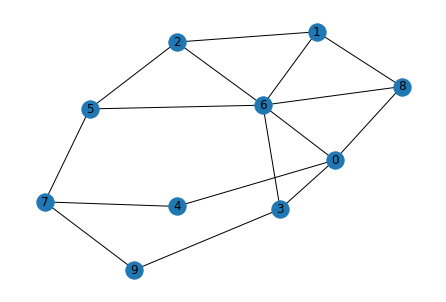